In [8]:

%matplotlib notebook
import matplotlib.pyplot
import numpy as np
from matplotlib import animation
import matplotlib.colors
import math

cmap = matplotlib.colors.ListedColormap(["#0099ff", "#d5d5c3", "#004d00", "#ff8533", "#787854", "#6B3031"])

# NORD : DIRECTION
# SUD : DIRECTION
# EST : DIRECTION
# OUEST : DIRECTION
def hasard(p):
    r = np.random.random()
    assert 0 <= p <= 1
    return r <= p


def creerForet(n, m, pcoccup, pw):
    """creer une foret de taille n,m avec pcoccup la proportion d'arbe et pw la proportion d'eau sur les elements incombustible"""
    foret = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            if hasard(pcoccup):
                foret[i, j] = 1.
            elif np.random.random() < pw:
                foret[i, j] = -1.
    return foret


def burnprob(foret, i, j):
    """defini le nombre de case d'eau a proximiter d'une case de vegetation """
    n, m = foret.shape
    u = 0.0
    if foret[i, j] == 1.:
        for r in range(max(0, i - 1), min(n, i + 2)):
            for g in range(max(0, j - 1), min(m, j + 2)):
                if foret[r, g] == -1.:
                    u += 0.05
    return u


def checkburn(foret, i, j, direction):
    """verifie si une case de vegetation est susceptible de bruler"""
    n, m = foret.shape
    if direction == 'NORD':
        for y in range(max(0, i - 1), min(n, i + 1)):
            if foret[y, j] == 2.:
                return True
        for x in range(max(0, j - 1), min(m, j + 2)):
            if foret[i, x] == 2.:
                return True

    return False


def mapburn(foret, direction):
    """creer une carte de la probabilite que chaque case a de bruler"""
    n, m = foret.shape
    mb = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            if foret[i, j] == 1.:
                mb[i, j] = 1.
                mb[i, j] = 1 - burnprob(foret, i, j)
                if checkburn(foret, i, j, direction) and not (peutbrulervent_nord(foret, i, j, direction)):
                    mb[i, j] = mb[i, j] - 0.15
    return mb


def mettreLeFeu(foret):
    """met le feu a une foret en un point"""
    n, m = foret.shape
    i = np.random.randint(0, n + 1)
    j = np.random.randint(0, m + 1)
    while foret[i, j] != 2.:
        if foret[i, j] == 1.:
            foret[i, j] = 2.
        else:
            i = np.random.randint(0, n)
            j = np.random.randint(0, m)

    pimpom(foret)
    return foret


def peutbrulervent_nord(foret, i, j, direction):
    """verifie si une case peut bruler a cause du vent"""
    n, m = foret.shape
    if direction == 'NORD':
        if i == n - 1:
            return False
        elif foret[i, j] == 1.:
            for v in range(max(0, j - 1), min(m, j + 2)):
                if foret[i + 1, v] == 2.:
                    return True
        else:
            return False

    elif direction == 'SUD':
        if i == 0.:
            return False
        elif foret[i, j] <= 1.:
            for v in range(max(0, j - 1), min(m, j + 2)):
                if foret[i - 1, v] == 2.:
                    return True
        else:
            return False

    elif direction == 'EST':
        if j == 0.:
            return False
        elif foret[i, j] == 1.:
            for v in range(max(0, i - 1), min(m, i + 2)):
                if foret[v, j - 1] == 2.:
                    return True
        else:
            return False
    elif direction == 'OUEST':
        if j == m - 1:
            return False
        elif foret[i, j] == 1.:
            for v in range(max(0, i - 1), min(m, i + 2)):
                if foret[v, j - 1] == 2.:
                    return True
        else:
            return False

    return False


def propageFeu(foret, direction):
    """propage le feu dans la foret"""
    n, m = foret.shape
    c = np.copy(foret)
    d = mapburn(c, direction)
    p = np.random.random()
    for i in range(n):
        for j in range(m):
            if peutbrulervent_nord(c, i, j, direction) and p < d[i, j]:
                foret[i, j] = 2.
            elif checkburn(c, i, j, direction) and p < d[i, j]:
                foret[i, j] = 2.
    for i in range(n):
        for j in range(m):
            if c[i, j] == 2. and np.random.random() < p:
                foret[i, j] = 3.
    pilot_pimpon(foret, direction)
    return foret


def auFeu(foret, direction):
    """verifie si il existe au moins une case qui peut bruler et s'il reste une case en feu"""
    n, m = foret.shape
    for i in range(n):
        for j in range(m):
            if peutbrulervent_nord(foret, i, j, direction) or checkburn(foret, i, j, direction) or foret[i, j] == 2.:
                return True
    return False


def compte(foret):
    nb = 0
    n, m = foret.shape
    for i in range(n):
        for j in range(m):
            if foret[i, j] == 1.:
                nb += 1
    return nb


def metFeuForet(foret, direction):
    foret = mettreLeFeu(foret)
    while auFeu(foret, direction):
        foret = propageFeu(foret, direction)
    return foret


def animationFeu(foret, direction, cmap=cmap):
    """creer l'animation de la propagation du feu dans la foret"""
    fig = matplotlib.pyplot.figure()
    cmap = cmap
    film = []

    foretFeu = mettreLeFeu(foret)
    film.append([matplotlib.pyplot.matshow(foret, fignum=False, cmap=cmap, vmin=-1, vmax=5., animated=True)])
    #matplotlib.pyplot.draw()

    while auFeu(foret, direction):
        foretFeu = propageFeu(foretFeu, direction)
        film.append([matplotlib.pyplot.matshow(foretFeu, fignum=False, cmap=cmap, vmin=-1, vmax=5., animated=True)])
        #matplotlib.pyplot.draw()
        cmap = cmap

    ani = animation.ArtistAnimation(fig, film, interval=1000, blit=True, repeat_delay=100)
    #matplotlib.pyplot.draw()
    #matplotlib.pyplot.show()

    return ani


def distance(G, H):
    """
    :type H: tuple[int,int]
    :type G: tuple[int,int]
    """
    x, y = G
    i, j = H

    return math.sqrt((y - i) ** 2 + (x - j) ** 2)


def pilot_pimpon(foret, direction):
    global yp, xp
    n, m = foret.shape
    """(k,l) : tuple[int, int]"""
    u = 10 ** 100
    L = []
    f = 0
    g = 0
    # yp : int
    # xp : int
    if auFeu(foret, direction):
        for i in range(n):
            for j in range(m):
                if foret[i, j] == 2.:
                    L.append((i, j))
        # recupperation de coordonee de pompier
        for y in range(n):
            for x in range(m):
                if foret[y, x] == 5.:
                    yp = y
                    xp = x
                    pass
        for i in L:
            k, b = i
            if distance((k, b), (yp, xp)) < u:
                u = distance((k, b), (yp, xp))  # coordonee du feu le plus proche
                f = k
                g = b
        # definition de la nouvelle position des pompiers
        f = f
        g = g
        foret[yp, xp] = -1.
        if yp > f:
            yp -= 2
        elif yp < f:
            yp += 2

        if xp > g:
            xp -= 2
        elif xp < g:
            xp += 2
        
        foret[yp, xp] = 5.

        return foret


def pimpom(foret):
    p = np.random.random()
    n, m = foret.shape
    if p < 0.25:
        foret[0, 0] = 5.
    elif p < 0.5:
        foret[0, m - 1] = 5.
    elif p < 0.75:
        foret[n - 1, 0] = 5.
    else:
        foret[n - 1, m - 1] = 5.
    return foret


<IPython.core.display.Javascript object>


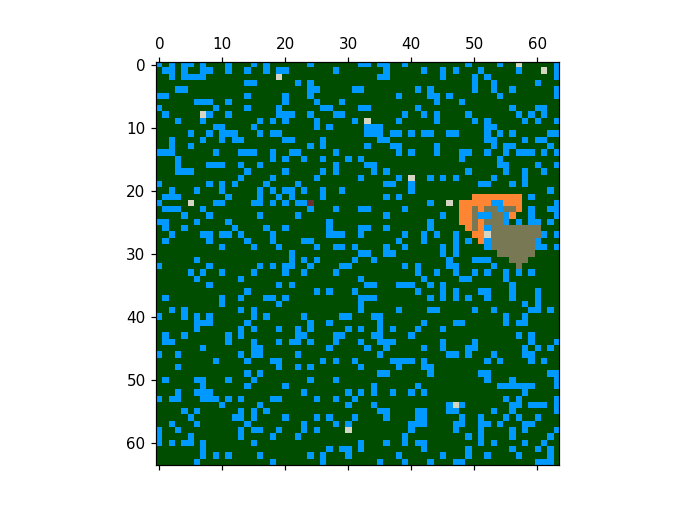

In [9]:
animationFeu(creerForet(64, 64, 0.8, 0.99), 'NORD')